<a href="https://colab.research.google.com/github/simulate111/Johdatus-teko-lyyn-Introduction-to-Artificial-Intelligence/blob/main/JT_H5_En_Solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input
plt.rcParams['figure.figsize'] = (13, 9)

In [ ]:
%%html
<style>
table td, table th, table tr {text-align:left !important;}
</style>

# <center>521160P Introduction to artificial intelligence<br><br>Exercise #5<br><br>Reinforcement and deep learning<br></center>

This exercise explores game strategies for Blackjack card game through reinforcement learning and teaches convolutional neural networks to identify categories of images through deep learning. **Look return deadlines from moodle** (Return instructions for this exercise are sligthly different from previous ones). It is possible to get 4 points from this exercise (2.0p + 2.0p).

If you have any questions related to exercises or you face any problems during this exercise please use moodle forum for **programming exercise 5**.

(*if you are using a 32-bit system and are having problems installing tensorflow, one option is to uninstall the current Python 3.8, install [Miniconda3 (64-bit)](https://docs.conda.io/en/latest/miniconda. html) (during installation, select All Users to install and add Miniconda3 to the PATH environment variable), run the command conda install jupyter matplotlib numpy scikit-image scikit-learn and the command conda install -c hesi_m tensorflow from the command line as an administrator. This version of tensorflow is unofficial and does not support the latest changes to tensorflow. However, it manages to use the basic functions of tensorflow. Perform this intermediate step only if you do not have tensorflow installed and your system is 32-bit.*)

**First fill in your group information (name and student number)**

# Group member information :

* **Member 1 :** `First_name Surname 1234567 `
* **Member 2 :** `Maija Meikäläinen 2345678 `
* **Member 3 :** `... `

# Task 1. Blackjack card game with reinforcement learning

In this task, game strategies for the Blackjack card game are solved through reinforcement learning. Let's first go through the rules of the simplified version of the game.

### Blackjack card game rules

At the beginning of the game, the player is dealt two cards face up and the dealer one card face up and one card face down. In a blackjack card game, the number cards 2-10 are worth their number, the picture cards are worth ten, and the ace is one or eleven, depending on desire. The player plays against the dealer and his goal is to get the sum of his cards higher than the sum of the dealer's cards. The sum of the cards must be as close as possible to 21, but must not go over, in which case the player loses the game. If a player's sum of cards on two starting cards is 21 as in Figure 1, he has blackjack. With this, the player wins all the hands of the dealer except the dealer's own blackjack, in which case the game ends in a draw. The player raises more cards from the deck until he is satisfied with the amount of his cards.

<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='https://github.com/simulate111/Johdatus-teko-lyyn-Introduction-to-Artificial-Intelligence/blob/main/imgs/blackjack.jpg?raw=1' width='600' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Figure 1. In a blackjack card game, the player has blackjack in the starting hand. </span>
</div>
<br>

Next, the turn moves to the dealer. The dealer must draw cards until the sum of his cards is 17 or greater. For example, if the sum of the dealer's cards is 18 and the sum of the player's cards is 19, the player wins the game. The player also wins the game when the sum of the dealer's cards exceeds 21. At the end of the game, the possible results are 17-17, 18-18, 19-19, 20-20 or 21-21.

Next, auxiliary functions are created for the implementation of the rules of the game and for the reinforcement learning algorithms.  

In [ ]:
def initialize_hand():
    """
    This function initializes the hand. The sum of the cards in the empty hand is 0 and does not include an ace.
    """
    empty_hand = (0, False)
    return empty_hand

def is_unsused_aces(hand):
    """
    This function checks to see if the hand contains unused aces.
    An ace is still available if the sum of the cards in the hand is less than 21 and a value of 11 has been used for the ace.
    """
    sum_of_cards, is_aces = hand
    return (is_aces and (sum_of_cards + 10) <= 21)

def calc_sum_of_cards(hand):
    """
    This function calculates the sum of the cards in the hand. If an ace is available, 10 is added to the sum of the cards.
    """
    sum_of_cards, is_aces = hand
    if is_unsused_aces(hand):
        return sum_of_cards + 10
    return sum_of_cards

def update_hand(hand, card_value):
    """
    This function updates the hand when new card is added
    """
    sum_of_cards, is_aces = hand
    sum_of_cards += card_value
    if card_value == 1:
        is_aces = True
    updated_hand = (sum_of_cards, is_aces)
    return updated_hand

def draw_card():
    """
    In this function, a card is drawn from a deck of infinitely many cards.
    Thus, after the draw, each card still has the same probability of being selected.
    the ace is 1, the number cards 2-10 are worth their number, and the picture cards are 10.
    """
    card_value = random.randint(1,13)
    if (card_value > 10):
        card_value = 10
    return card_value

def deal_player_starting_hand():
    """
    This function deals the player's starting hand.
    In terms of game strategy, it is interesting to find out how a player plays when the sum of his cards is over 11.
    """
    hand = initialize_hand()
    for i in range(2):
        card_value = draw_card()
        hand = update_hand(hand, card_value)
    while calc_sum_of_cards(hand) < 11:
        card_value = draw_card()
        hand = update_hand(hand, card_value)
    return hand

def deal_dealer_starting_hand():
    """
    This function deals dealer's starting hand
    """
    hand = initialize_hand()
    card_value = draw_card()
    hand = update_hand(hand, card_value)
    return hand, card_value

def pelaa_dealer_vuoro(hand):
    """
    In this function, the dealer raises a new card until the sum of the cards in his/her hand is 17 or greater.
    """
    while calc_sum_of_cards(hand) < 17:
        card_value = draw_card()
        hand = update_hand(hand, card_value)
    return hand

def generate_states():
    """
    This function returns all possible states of the game in the list. The value of the dealer's card is between 1-10,
    the sum of the player's cards is 11-21 and the player's hand either contains an ace or not.
    """
    states = []
    for dealer_card_value in range(1,11):
        for player_sum_of_cards in range(11,22):
            states.append((dealer_card_value, player_sum_of_cards, False))
            states.append((dealer_card_value, player_sum_of_cards, True))
    return states

def start_game_from_state(state):
    """
    This function starts the game when it is given state information at the beginning of the game.
    """
    dealer_card_value, player_sum_of_cards, is_aces = state
    if is_aces:
        player_sum_of_cards -= 10
    player_hand = (player_sum_of_cards, is_aces)
    dealer_hand = initialize_hand()
    dealer_hand = update_hand(dealer_hand, dealer_card_value)
    return dealer_card_value, dealer_hand, player_hand

def initialize_state_motion_table_values():
    """
    This function initializes the values of the state motion table with zeros. Movement True means that the player raises a new card and
    movement False, the player decides his turn, being happy with his cards.
    """
    states = generate_states()
    state_motion_table = {}
    for state in states:
        state_motion_table[(state,True)] = 0.0
        state_motion_table[(state,False)] = 0.0
    return state_motion_table

def change_state_from_hand(card_value, player_hand):
    """
    This function converts player's hand into state
    """
    player_sum_of_cards = calc_sum_of_cards(player_hand)
    is_aces = is_unsused_aces(player_hand)
    return (card_value, player_sum_of_cards, is_aces)

def find_random_state(states):
    """
    In this function, the state is randomly selected from all possible states.
    """
    random_index = random.randint(0,len(states)-1)
    state = states[random_index]
    return state

def choose_random_move():
    """
    In this function, one of the moves is randomly selected to raise a new card and end the turn.
    """
    random_num = random.randint(1,2)
    return random_num == 1

def choose_best_move(Q, state):
    """
    In this function, the better of the two possible movements is selected based on the Q values.
    """
    if Q[(state,True)] > Q[(state,False)]:
        return True
    return False

def give_game_feedback (player_hand, dealer_hand):
    """
    This function provides feedback on the outcome of the game.
    """
    player_sum_of_cards = calc_sum_of_cards(player_hand)
    dealer_sum_of_cards = calc_sum_of_cards(dealer_hand)
    if player_sum_of_cards > 21:
        return -1
    if dealer_sum_of_cards > 21:
        return 1
    if player_sum_of_cards < dealer_sum_of_cards:
        return -1
    if player_sum_of_cards == dealer_sum_of_cards:
        return 0
    if player_sum_of_cards > dealer_sum_of_cards:
        return 1

An ace has a big impact on game strategy, so it’s important to separate the states when a player has an ace in their hand and when they don’t.

The state of the game contains three values: the value of the dealer's starting hand, the sum of the cards in the player's hand, and whether the player's hand contains an ace. In Game State, a player has the ability to make two types of moves: 1) raise one more card or 2) decide their turn while being happy with the amount of their cards. The choice of movement can be made randomly or use previously learned information to benefit from the selection.

Feedback on the outcome of the game is given according to how it ended. when the player wins the feedback is 1, at the end of the game the tie is 0 and when the dealer wins the feedback is -1.

### Monte Carlo-simulaatio

Next, a Monte Carlo simulation is performed. Since the Blackjack card game is a stationary process, the learning rate is $\alpha=\frac{1}{N (S_{t}, A_{t})}$. The Monte Carlo simulation updates the Q values according to Equation 1.

<br>
\begin{equation}
Q(S_{t}, A_{t}) \leftarrow Q(S_{t}, A_{t}) + \alpha \: (R_{t}-Q(S_{t}, A_{t})) \tag{1}
\end{equation}
<br>

The Epsilon-Greedy strategy alternates between random and best movement selection, for example, by selecting nine out of ten times the best-observed movement and one out of ten random movement.

Implement the Monte Carlo simulation update rule to calculate Q-values and the epsilon-Greedy strategy to select motion.

In [ ]:
def update_monte_carlo_simulation(N, Q, state_motion_pair, R):
    """
    This function updates the number of visited state motion pairs in Table N and Q Table values
    """
    # Add the number of state-owned business pairs visited to the business-to-business pair in Table One
    N[state_motion_pair] += 1
    #-------YOUR CODE HERE--------
    # update state motion pair new Q-value with Monte Carlo simulation update rule when alpha = 1 / N [state_motion_pair]
    Q[state_motion_pair] += (R - Q[state_motion_pair]) / N[state_motion_pair]
    #--------------------------------
    return N, Q

def use_epsilon_greedy_strategy(Q, state, epsilon):
    """
    This function uses the epsilon-Greedy strategy for motion selection.
    The percentage indicated by the epsilon value indicates how often random motion is selected.
    Otherwise, the best possible motion is selected.
    """
    #-------YOUR CODE HERE--------
    # Pick random value between 0 and 1 (Hint: random.random ())
    random_value = random.random()
    # If the drawn number is less than epsilon
    if random_value < epsilon:
        # The function returns a randomly selected move, i.e. the function choose_random_move()
        return choose_random_move()
    # Otherwise, the function returns the best motion, ie the function choose_best_move(Q, state)
    else:
        return choose_best_move(Q, state)
    #--------------------------------

def run_monte_carlo_simulation(number_of_iterations, epsilon):
    """
    This function performs a Monte Carlo simulation for a Blackjack card game.
    """
    # Initialize with zeros the values of the state motion pairs and how many times the state motion pairs have been visited
    Q = initialize_state_motion_table_values()
    N = initialize_state_motion_table_values()
    # Generate states
    states = generate_states()
    for i in range(number_of_iterations):
        state_motion_pairs = []
        # Select state and move at random
        state = find_random_state(states)
        move = choose_random_move()
        dealer_card_value, dealer_hand, player_hand = start_game_from_state(state)
        # Adding a state motion pair to the list
        state_motion_pairs.append((state, move))
        # The player draws new cards until the sum of the cards exceeds 21
        while move:
            player_hand = update_hand(player_hand, draw_card())
            if calc_sum_of_cards(player_hand) > 21:
                break
            state = change_state_from_hand(dealer_card_value, player_hand)
            move = use_epsilon_greedy_strategy(Q, state, epsilon)
            state_motion_pairs.append((state, move))
        # The dealer's turn to play when the player decides to end his/her turn
        dealer_hand = pelaa_dealer_vuoro(dealer_hand)
        # Calculate the value of the feedback
        R = give_game_feedback(player_hand, dealer_hand)
        # Updating Q values
        for state_motion_pair in state_motion_pairs:
            N, Q = update_monte_carlo_simulation(N, Q, state_motion_pair, R)
    return Q

# Perform a Monte Carlo simulation
# It will take a while to run this step
Q_monte_carlo = run_monte_carlo_simulation(1000000, 0.1)

Plotting the Q-values determined by the Monte Carlo simulation on a three-dimensional graph of moves, lift a new card and decide the turn when the player has an ace in his/her hand and when there are none.

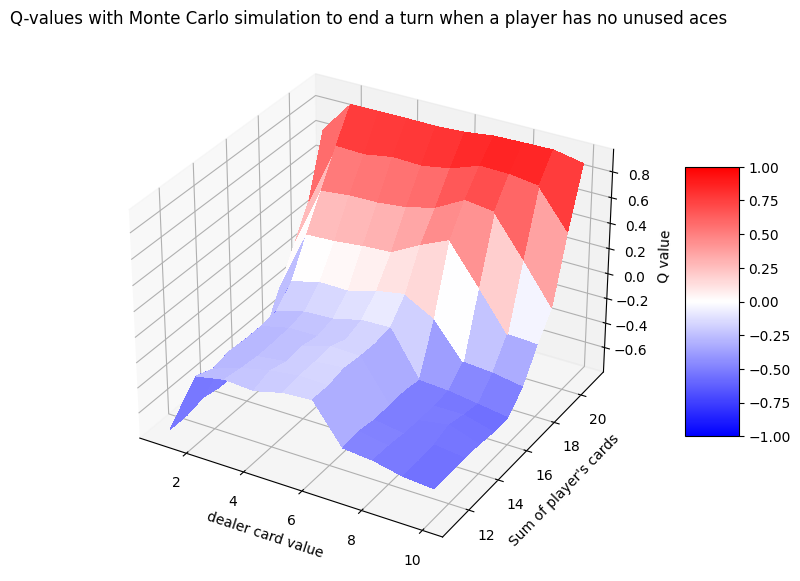

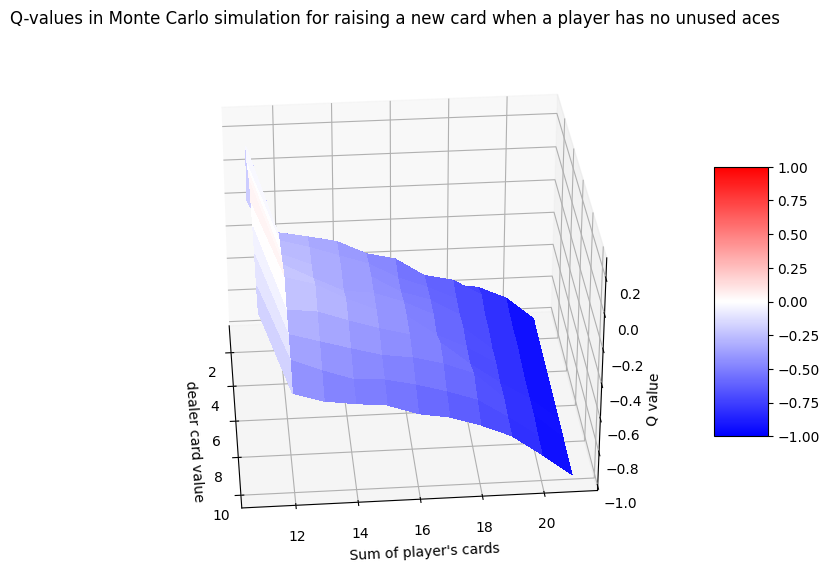

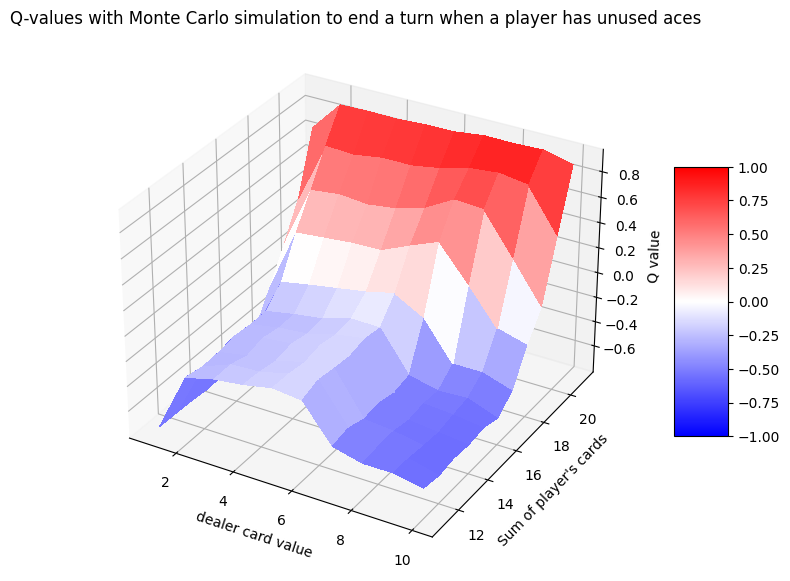

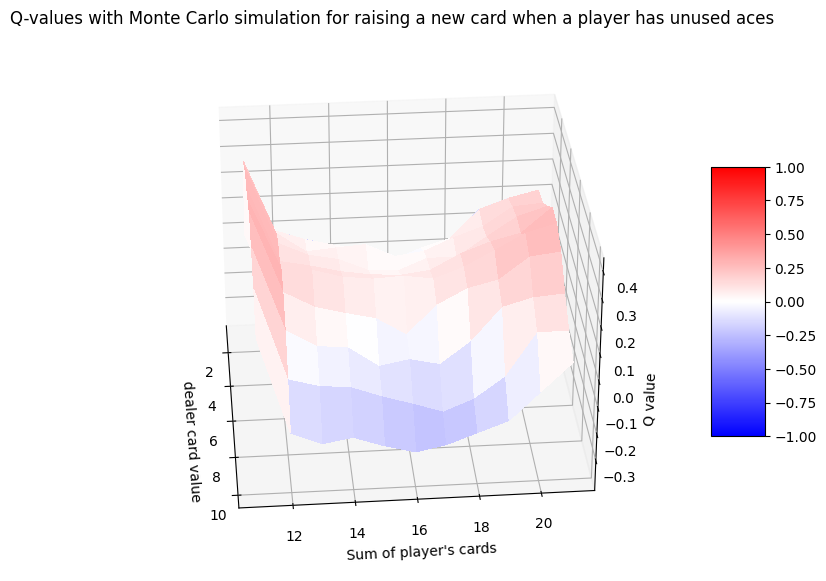

In [ ]:
def draw_q_values_on_graph(Q, X, Y, Z, header, is_aces, pick_card, azim=-60):
    """
    In this function, the Q-values are plotted on a three-dimensional graph for a given game movement and the condition of whether there is an ace in the hand.
    """
    for key, Q_arvo in Q.items():
        if key[0][2] == is_aces and key[1] == pick_card:
            Z[key[0][1]-11][key[0][0]-1] = Q_arvo
    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(azim=azim)
    surface = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, vmin=-1, vmax=1, cmap=cm.bwr, linewidth=0, antialiased=False)
    ax.set_ylabel('Sum of player\'s cards')
    ax.set_xlabel('dealer card value')
    ax.set_zlabel('Q value')
    ax.set_title(header)
    fig.colorbar(surface, shrink=0.5, aspect=5)

# Initialize the values of the graph axes
X = np.arange(1,11)
Y = np.arange(11,22)
Z = np.zeros((11,10))
X, Y = np.meshgrid(X, Y)

# Q-values with Monte Carlo simulation to end a turn when a player has no unused aces
header = 'Q-values with Monte Carlo simulation to end a turn when a player has no unused aces'
draw_q_values_on_graph(Q_monte_carlo, X, Y, Z, header, False, False)

# Q-values in Monte Carlo simulation for raising a new card when a player has no unused aces
header = 'Q-values in Monte Carlo simulation for raising a new card when a player has no unused aces '
draw_q_values_on_graph(Q_monte_carlo, X, Y, Z, header, False, True, azim=355)

# Q-values with Monte Carlo simulation to end a turn when a player has unused aces
header = 'Q-values with Monte Carlo simulation to end a turn when a player has unused aces '
draw_q_values_on_graph(Q_monte_carlo, X, Y, Z, header, True, False)

# Q-values with Monte Carlo simulation for raising a new card when a player has unused aces
header = 'Q-values with Monte Carlo simulation for raising a new card when a player has unused aces '
draw_q_values_on_graph(Q_monte_carlo, X, Y, Z, header, True, True, azim=355)
plt.show()

The game strategy determined by the Monte Carlo simulation is printed by selecting the move with the highest Q value from the state-move table for the states.

In [ ]:
def print_game_strategy(Q, algorithm_name):
    """
    This function prints the game strategy by selecting a move with a higher Q value from the moves.
    """
    print('Game strategy solved with {} (X raise the card , * end turn).\nThe vertical axis shows the sum of the player cards and the horizontal axis the value of the dealer card.'.format(algorithm_name))
    for is_aces_bool in [True, False]:
        if is_aces_bool:
            print('\nThe player has unused aces\n')
        else:
            print('\nThe player has no unused aces\n')
        for player_hand_value in range(21,10,-1):
            for dealer_card in range(1,11):
                if (Q[((dealer_card,player_hand_value,is_aces_bool),True)] > Q[((dealer_card,player_hand_value,is_aces_bool),False)]):
                    print(' X', end='')
                else:
                    print(' *', end='')
            print(' | {}'.format(player_hand_value))
        print('---------------------')
        print(' A 2 3 4 5 6 7 8 9 10')

# The game strategy determined by the Monte Carlo simulation is printed
print_game_strategy(Q_monte_carlo, 'Monte Carlo-simulaatio')

Game strategy solved with Monte Carlo-simulaatio (X raise the card , * end turn).
The vertical axis shows the sum of the player cards and the horizontal axis the value of the dealer card.

The player has unused aces

 * * * * * * * * * * | 21
 * * * * * * * * * * | 20
 * * * * * * * * * * | 19
 X * * * * * * * X X | 18
 X X X X X X X X X X | 17
 X X X X X X X X X X | 16
 X X X X X X X X X X | 15
 X X X X X X X X X X | 14
 X X X X X X X X X X | 13
 X X X X X X X X X X | 12
 X X X X X X X X X X | 11
---------------------
 A 2 3 4 5 6 7 8 9 10

The player has no unused aces

 * * * * * * * * * * | 21
 * * * * * * * * * * | 20
 * * * * * * * * * * | 19
 * * * * * * * * * * | 18
 * * * * * * * * * * | 17
 X * * * * * X X X * | 16
 X * * * * * X X X X | 15
 X * * * * * X X X X | 14
 X * * * * * X X X X | 13
 X X * * * * X X X X | 12
 X X X X X X X X X X | 11
---------------------
 A 2 3 4 5 6 7 8 9 10


**If the value of the dealer's card is 4, the sum of the player's cards is 15 and the player has no unused aces, what should he do based on the game strategy determined by the Monte Carlo simulation?**

`* end turn`

### Q learning

Next, Q-learning is performed. Now use the learning speed value $\alpha=\frac{\alpha}{n(s_{t}, a_{t})}$. Q learning updates Q values in accordance with equation 2.

<br>
\begin{equation}
Q(S_{t},A_{t}) \leftarrow Q(S_{t},A_{t}) + \alpha \: [R_{t} + \gamma \max (Q(S_{t+1},A_{t})) - Q(S_{t},A_{t})] \tag{2}
\end{equation}
<br>

In [ ]:
def run_q_learning(number_of_iterations, epsilon, learning_speed):
    """
    This function executes a Q learning algorithm for a Blackjack card game.
    """
    # Initialize the values of the state-move pairs with zeros and how many times the state-move pairs have been visited
    Q = initialize_state_motion_table_values()
    N = initialize_state_motion_table_values()
    # Generate states
    states = generate_states()
    for i in range(number_of_iterations ):
        # Pick state randomly
        state = find_random_state(states)
        dealer_card_value, dealer_hand, player_hand = start_game_from_state(state)
        while (True):
            # Choose next move with epsilon greedy strategy
            move = use_epsilon_greedy_strategy(Q, state, epsilon)
            state_motion_pair = (state, move)
            if move:
                # The player draws new cards until the sum of the cards exceeds 21
                card_value = draw_card()
                player_hand = update_hand(player_hand, card_value)
                if calc_sum_of_cards(player_hand) > 21:
                    # Update Q value
                    N[state_motion_pair] += 1
                    Q[state_motion_pair] += (learning_speed/N[state_motion_pair]) * ((-1) - Q[state_motion_pair])
                    break
                else:
                    # Update Q value
                    next_state = change_state_from_hand(dealer_card_value, player_hand)
                    Q_value_max = Q[(next_state,False)]
                    if (Q[(next_state,True)] > Q_value_max):
                        Q_value_max = Q[(next_state,True)]
                    N[state_motion_pair] += 1
                    Q[state_motion_pair] += (learning_speed/N[state_motion_pair]) * (Q_value_max - Q[state_motion_pair])
                    # Update state
                    state = next_state
            else:
                # Dealer's turn to play when player ends turn
                dealer_hand = pelaa_dealer_vuoro(dealer_hand)
                # Calculate feedback value
                R = give_game_feedback (player_hand, dealer_hand)
                # Update Q-value
                N[state_motion_pair] += 1
                Q[state_motion_pair] += (learning_speed/N[state_motion_pair]) * (R - Q[state_motion_pair])
                break
    return Q

# Perform Q-learning
# It will take a while to run this step
Q_q_oppiminen = run_q_learning(1000000, 0.05, 0.999)

Plotting the Q-values determined by Q-learning on a three-dimensional graph of moves, lift a new card and end the turn when the player has an ace in her/his hand and when there are none

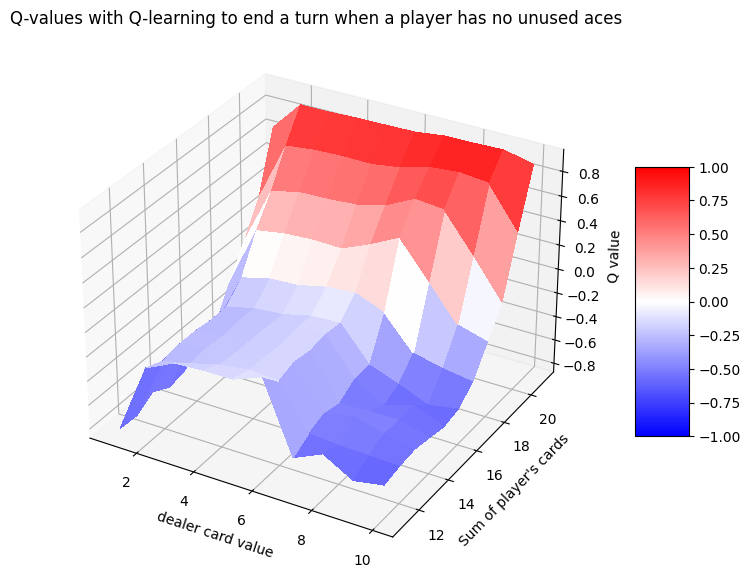

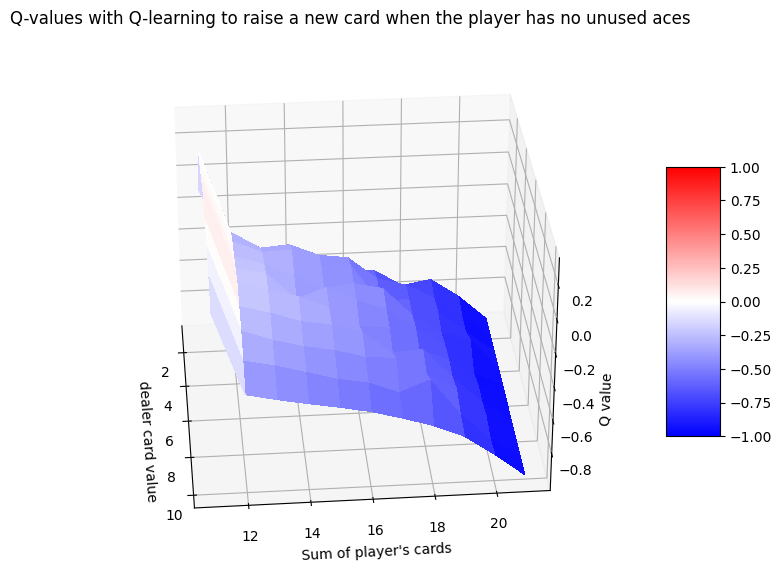

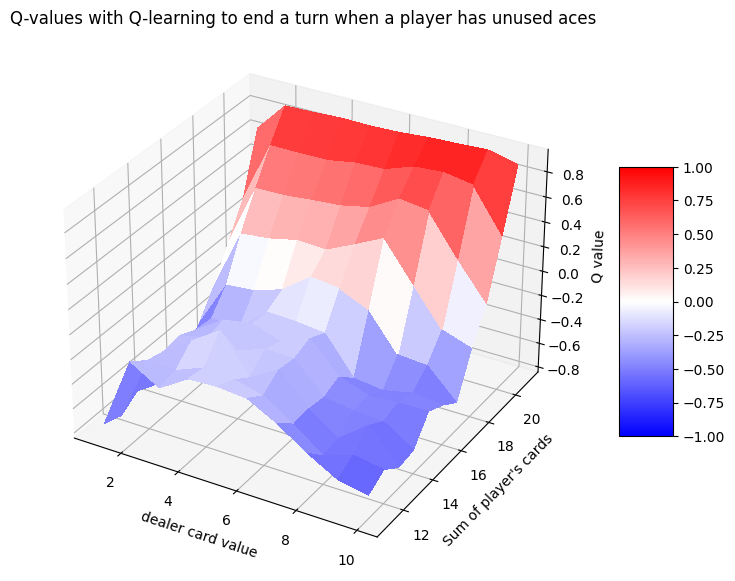

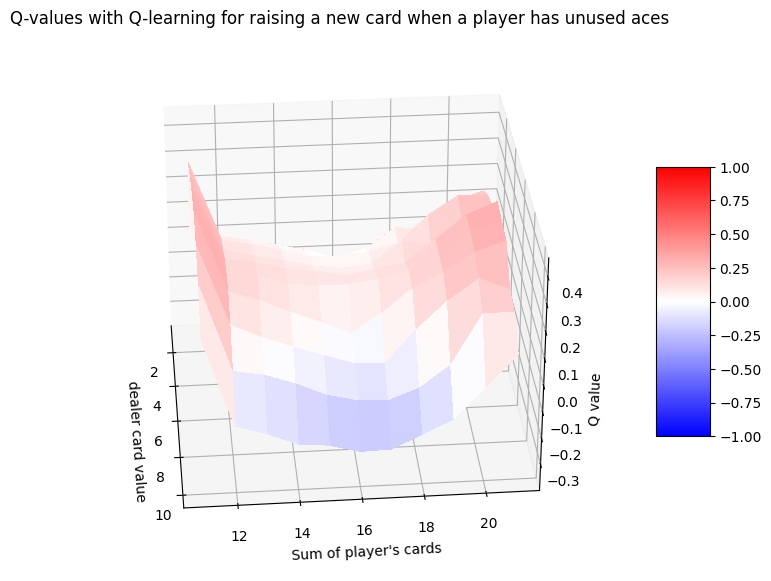

In [ ]:
# Initialize the values of the graph axes
X = np.arange(1,11)
Y = np.arange(11,22)
Z = np.zeros((11,10))
X, Y = np.meshgrid(X, Y)

# Q-values with Q-learning to end a turn when a player has no unused aces
header = 'Q-values with Q-learning to end a turn when a player has no unused aces '
draw_q_values_on_graph(Q_q_oppiminen, X, Y, Z, header, False, False)

# Q values with Q-learning to raise a new card when the player has no unused ace
header = 'Q-values with Q-learning to raise a new card when the player has no unused aces'
draw_q_values_on_graph(Q_q_oppiminen, X, Y, Z, header, False, True, azim=355)

# Q-values with Q-learning to end a turn when a player has unused aces
header = 'Q-values with Q-learning to end a turn when a player has unused aces'
draw_q_values_on_graph(Q_q_oppiminen, X, Y, Z, header, True, False)

# Q-values with Q-learning for raising a new card when a player has unused aces
header = 'Q-values with Q-learning for raising a new card when a player has unused aces'
draw_q_values_on_graph(Q_q_oppiminen, X, Y, Z, header, True, True, azim=355)
plt.show()

The game strategy determined by Q-learning is printed by selecting the move with the highest Q-value from the state-move table.

In [ ]:
# Let's print out the game strategy determined by Q-learning
print_game_strategy(Q_q_oppiminen, 'Q-oppimise')

Game strategy solved with Q-oppimise (X raise the card , * end turn).
The vertical axis shows the sum of the player cards and the horizontal axis the value of the dealer card.

The player has unused aces

 * * * * * * * * * * | 21
 * * * * * * * * * * | 20
 * * * * * * * * * * | 19
 X * * * * * * * X X | 18
 X X X X X X X X X X | 17
 X X X X X X X X X X | 16
 X X X X X X X X X X | 15
 X X X X X X X X X X | 14
 X X X X X X X X X X | 13
 X X X X X X X X X X | 12
 X X X X X X X X X X | 11
---------------------
 A 2 3 4 5 6 7 8 9 10

The player has no unused aces

 * * * * * * * * * * | 21
 * * * * * * * * * * | 20
 * * * * * * * * * * | 19
 * * * * * * * * * * | 18
 * * * * * * * * * * | 17
 X * * * * * X X X X | 16
 X * * * * * X X X X | 15
 X * * * * * X X X X | 14
 X * * * * * X X X X | 13
 X X X * * X X X X X | 12
 X X X X X X X X X X | 11
---------------------
 A 2 3 4 5 6 7 8 9 10


One casino promises to return the player's bet twice the winnings of the Blackjack game. In a draw, the stake is returned as is and at a loss the player loses his stake.

Finally, let’s look at how well the game strategies figured out outperform that casino based on the payout percentage when both strategies play 100,000 games.

In [ ]:
def calc_payback_percentage (Q, number_of_games):
    """
    This function calculates the payback percentage for the game strategy when playing many games in a row.
    """
    payback = 0
    states = generate_states()
    for i in range(number_of_games):
        state = find_random_state(states)
        dealer_card_value, dealer_hand, player_hand = start_game_from_state(state)
        while True:
            move = choose_best_move(Q, state)
            state_motion_pair = (state, move)
            if move:
                # The player draws new cards until the sum of the cards is over 21
                card = draw_card()
                player_hand = update_hand(player_hand, card)
                if calc_sum_of_cards(player_hand) > 21:
                    R = give_game_feedback (player_hand, dealer_hand)
                    payback += R
                    break
            else:
                # Dealer's turn to play, after player ends turn
                dealer_hand = pelaa_dealer_vuoro(dealer_hand)
                # Calculate feedback value
                R = give_game_feedback (player_hand, dealer_hand)
                payback += R
                break
    return (number_of_games + payback)/number_of_games

print('Payback percentage for the game strategy determined by the Monte Carlo simulation: {} %\n'.format(round(100*calc_payback_percentage (Q_monte_carlo, 100000),3)))
print('Payback percentage for game strategy determined by Q-learning: {} %\n'.format(round(100*calc_payback_percentage(Q_q_oppiminen, 100000),3)))

Payback percentage for the game strategy determined by the Monte Carlo simulation: 64.47 %

Payback percentage for game strategy determined by Q-learning: 63.792 %



**Which of the game strategies is better? Is it worth playing Blackjack at that casino with these gaming strategies?**

`Monte Carlo has the higher chance than Q-learning.

As the chance is over 50%, then it is a good idea to do it However, the chance of loosing money is still very high.`

## Task 2. Teaching convolution neural networks

The second task is to train three convolutional neural networks to classify images. In this task the Cifar-10 dataset is used. The dataset contains 60,000 RGB images of size 32 x 32 pixels. The dataset contains 10 classes of objects such as passenger cars, birds and cats. To reduce the training and validation time, a subset of 5000 samples for both training and validation is used. Figure 2 shows example images of all the classes.

<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='https://github.com/simulate111/Johdatus-teko-lyyn-Introduction-to-Artificial-Intelligence/blob/main/imgs/cifar10.png?raw=1' width='950' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Figure 2. Example images of data CIFAR-10 from all classes.</span>
</div>
<br>

The CIFAR-10 dataset is loaded and divided into teaching and validation datasets.

In [ ]:
# Load CIFAR-10 data
(data_teaching, classes_teaching), (data_validation, classes_validation) = cifar10.load_data()
data_teaching, classes_teaching, data_validation, classes_validation = data_teaching[:5000], classes_teaching[:5000], data_validation[:5000], classes_validation[:5000]
data_teaching, data_validation = data_teaching.astype('float32'), data_validation.astype('float32')
data_teaching /= 255
data_validation /= 255

# Find ammount of classes
class_ammount = len(list(set(classes_teaching.reshape(-1).tolist())))
class_names = ['airplane','car','bird','cat','deer','dog','frog','horse','boat','truck']

# Transform classes into categorical form with one-hot encoding
classes_teaching_categorical = keras.utils.to_categorical(classes_teaching, class_ammount)
classes_validation_categorical = keras.utils.to_categorical(classes_validation, class_ammount)

In deep learning, an epoch is the process of feeding the entire training dataset into the model once. Usually the training requires several epochs. Often the data is fed to the model in batches instead of as individual samples. The model parameters are updated after each batch. For example, if the teaching data has 1024 samples and a batch size is 8 samples, 128 iterations are performed during one epoch.

The learning process of a neural network model can be monitored by seeing how the loss value (or classification rate, etc.) developes over epochs. In Figure 3, the red training data classification rate is plotted with two validation classification rates. The training data classification rate keeps getting better while the green and blue curves show the small and large amounts of overfitting, respectively. Training should be stopped when the validation classification accuracy reaches its maximum and validation loss is minimal.

<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='https://github.com/simulate111/Johdatus-teko-lyyn-Introduction-to-Artificial-Intelligence/blob/main/imgs/luokittelutarkkuus.png?raw=1' width='350' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Figure 3. The difference between the classification accuracy of teaching data and validation data is directly proportional to the number of administration. </span>
</div>
<br>

Your job is to create and teach three different convolutional neural networks and evaluate their performance. Model Model 1, Model 2 and Model 3 Structures can be found in Table 1. Model 1 has been used for two convolutional layer, activation function, and maximum sub-sampling layer. In the model 2, there are additionally neuron dropout layers and model 3 normalization for a batch. In Table 1, each layer can be found in the brackets within the description of the features after transformation of dimensions

Model 1 is pre-implemented as an example for the implementation of models 2 and 3. Use the following for the functions of the Keras library when adding layers: convolution ([Conv2D()](https://keras.io/layers/convolutional/)), activation function ([Activation()](https://keras.io/layers/core/)), max pooling ([Maxpooling2D()](https://keras.io/layers/pooling/), neuron dropout layer ([Dropout()](https://keras.io/layers/core/)), normalization for batch ([BatchNormalization()](https://keras.io/layers/normalization/)) , input layer([Flatten()](https://keras.io/layers/core/)), the hidden layer and the output layer ([Dense()](https://keras.io/layers/core/)).

<br>
<div style="width:image width px; font-size:80%; text-align:left;">
    <span>Table 1. Structures of convulution networks used in this exercise</span>

| Model 1 | Model 2 | Model 3 |
|   ---   |   ---   |   ---   |
| RGB-image (32x32x3) | RGB-image (32x32x3) | RGB-image (32x32x3) |
| <br> | <br> | <br> |
| 3x3 convolution, 32 layers with zero padding (32x32x32) | 3x3 convolution, 32 layers with zero padding (32x32x32) | 3x3 convolution, 32 layers with zero padding (32x32x32) |
| ReLU-activation function (32x32x32) | ReLU-activation function (32x32x32) | ReLU-activation function (32x32x32) |
| 3x3 convolution, 32 layers with zero padding (32x32x32) |3x3 convolution, 32 layers with zero padding (32x32x32) | Normalization according to batch(32x32x32) |
| ReLu-activation function (32x32x32) | ReLu-activation function (32x32x32) | 3x3 convolution, 32 layers with zero padding (32x32x32) |
| 2x2 max pooling (16x16x32) | 2x2 max pooling (16x16x32) | ReLu-activation function (32x32x32) |
| <br> | 30 % neuron dropout layer (16x16x32) | Normalization according to batch size (32x32x32) |
| 3x3 convolution, 64 layers with zero padding (16x16x64) | <br> | 2x2 max pooling (16x16x32) |
| ReLu-activation function (16x16x64) | 3x3 convolution, 64 layers with zero padding (16x16x64) | 30 % neuron dropout layer (16x16x32) |
| 3x3 convolution, 64 layers with zero padding (16x16x64) | ReLu-activation function (16x16x64) | <br> |
| ReLu-activation function (16x16x64) | 3x3 convolution, 64 layers with zero padding (16x16x64) | 3x3 convolution, 64 layers with zero padding (16x16x64) |
| 2x2 max pooling (8x8x64) | ReLu-activation function (16x16x64) | ReLu-activation function (16x16x64) |
| <br> | 2x2 max pooling (8x8x64) | Normalization according to batch size (16x16x64) |
| input layer (4096) | 40 % neuron dropout layer (8x8x64) | 3x3 convolution, 64 layers with zero padding (16x16x64) |
| hidden layer (128) | <br> | ReLu-activation function (16x16x64) |
| ReLu-activation function (128) | input layer (4096) | Normalization according to batch size (16x16x64) |
| Dense layer (10) | hidden layer (128) | 2x2 max pooling (8x8x64) |
| Softmax activation function (10) | ReLu-activation function (128) | 40 % neuron dropout layer (8x8x64) |
| <br> | 50 % neuron dropout layer (128) | <br> |
| <br> | Dense layer (10) | input layer (4096) |
| <br> | Softmax activation function (10) | hidden layer (128) |
| <br> | <br> | ReLu-activation function (128) |
| <br> | <br> | Normalization according to batch size (128) |
| <br> | <br> | 50 % neuron dropout layer (128) |
| <br> | <br> | Dense layer (10) |
| <br> | <br> | Softmax activation function (10) |
</div>
<br>

An example of a convolutional neural  network model 1 is created and teaching it with CIFAR-10 data 20 cycles when a batch size is 64 samples. You can reduce the size of the batch (the variable *batch_size*) to 32 or 16 samples, if your computer's memory is limited. Draw graph for model 1 and add teaching procesess', teaching data's and validation data's classification accuracies and losses in it.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 ReLU_1 (Activation)         (None, 32, 32, 32)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 32, 32, 32)        9248      
                                                                 
 ReLU_2 (Activation)         (None, 32, 32, 32)        0         
                                                                 
 MaxPooling_1 (MaxPooling2D  (None, 16, 16, 32)        0         
 )                                                               
                                                                 
 Conv_3 (Conv2D)             (None, 16, 16, 64)        18496     
                                                           

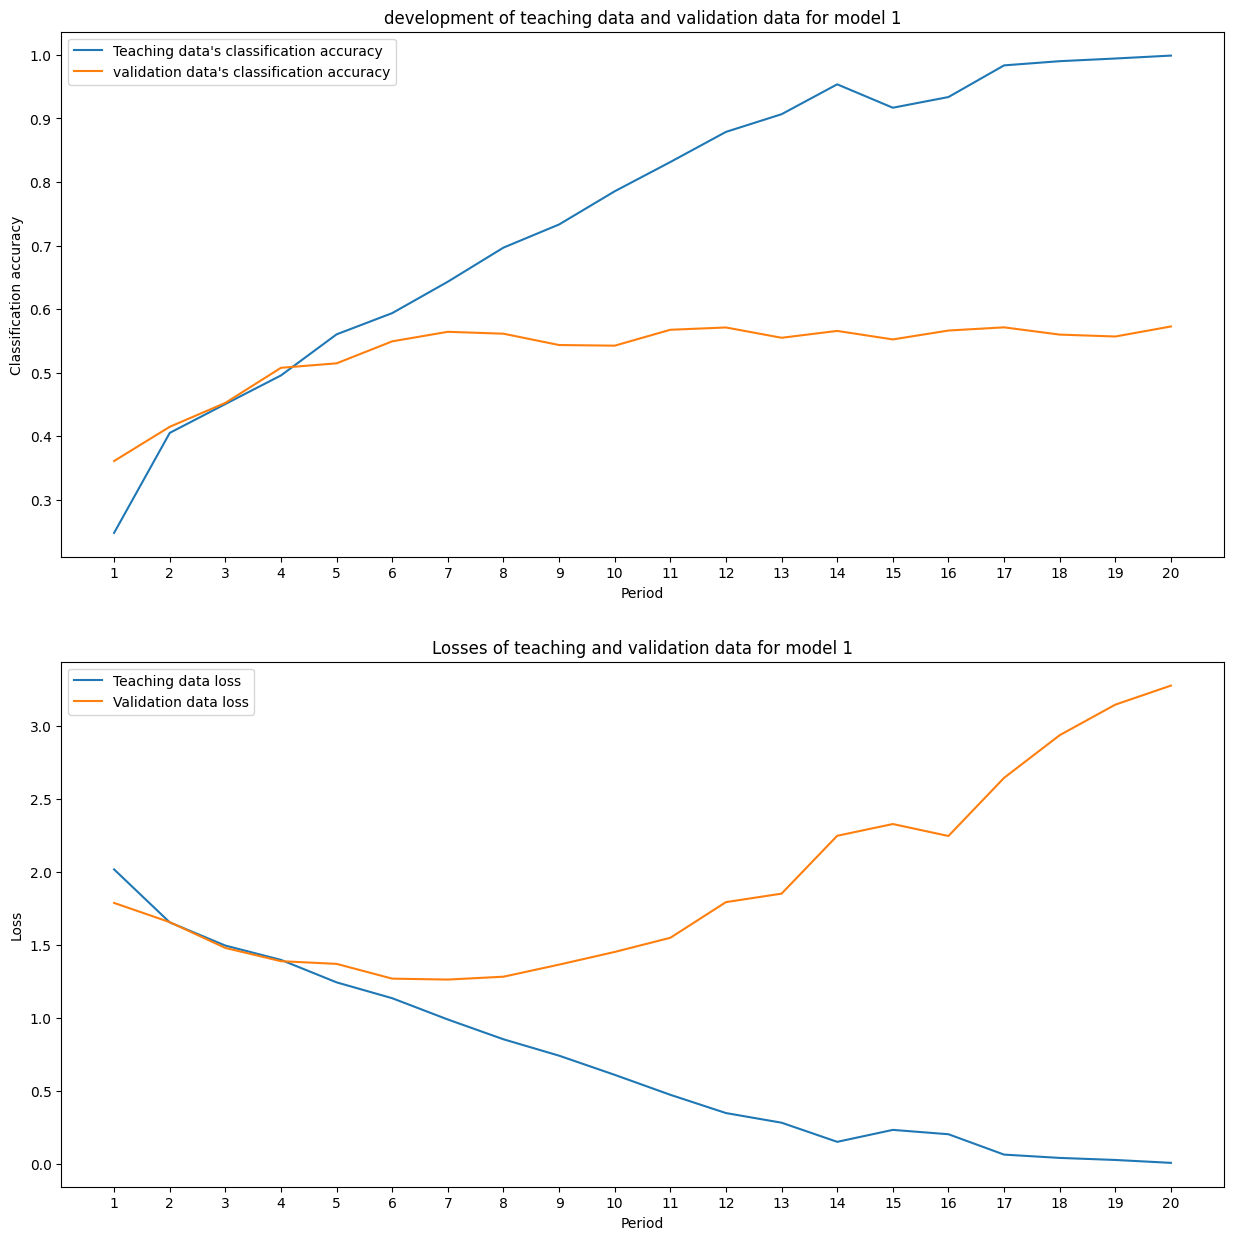

Classification accuracy for teaching data 20 after teaching period 99.88 %
Classification accuracy for validation data 20 after teaching period 57.28 %
Teaching data loss 20 after teaching period 0.008
Validation data loss 20 after teaching period 3.276


In [ ]:
def draw_graph_teaching_process(model, model_name):
    """
    This function is drawn to the graph of the classification accuracy of teaching data and validation data and losses as teaching progresses.
    """
    # Draw classification accuracies and losses of teaching process, teaching data and validation data
    fig, ax = plt.subplots(2, 1, figsize=(15,15))
    periods = np.arange(len(model.history['accuracy']))+1
    ax[0].plot(periods, model.history['accuracy'])
    ax[0].plot(periods, model.history['val_accuracy'])
    teaching_data_accuracy = model.history['accuracy'][-1]
    validation_data_accuracy = model.history['val_accuracy'][-1]
    teaching_data_loss = model.history['loss'][-1]
    validation_data_loss = model.history['val_loss'][-1]
    ax[0].set_title('development of teaching data and validation data for model {}'.format(model_name))
    ax[0].set_xlabel('Period')
    ax[0].set_ylabel('Classification accuracy')
    ax[0].set_xticks(np.arange(len(model.history['accuracy']))+1)
    ax[0].legend(['Teaching data\'s classification accuracy', 'validation data\'s classification accuracy'], loc='upper left')

    ax[1].plot(periods, model.history['loss'])
    ax[1].plot(periods, model.history['val_loss'])
    ax[1].set_title('Losses of teaching and validation data for model {}'.format(model_name))
    ax[1].set_xlabel('Period')
    ax[1].set_ylabel('Loss')
    ax[1].set_xticks(np.arange(len(model.history['accuracy']))+1)
    ax[1].legend(['Teaching data loss', 'Validation data loss'], loc='upper left')
    plt.show()

    # Prints after teaching teaching and validation data's classification accuracies and losses
    print('Classification accuracy for teaching data {} after teaching period {} %'.format(periods.size, round(100*teaching_data_accuracy,3)))
    print('Classification accuracy for validation data {} after teaching period {} %'.format(periods.size, round(100*validation_data_accuracy,3)))
    print('Teaching data loss {} after teaching period {}'.format(periods.size, round(teaching_data_loss,3)))
    print('Validation data loss {} after teaching period {}'.format(periods.size, round(validation_data_loss,3)))

def create_model1():
    """
    This function creates convolutional network according to model1
    """
    # Initialize model1 consisting of consequent layers
    model1 = Sequential(name='model_1')
    model1.add(Input(shape=(32,32,3)))

    # Add 3x3 convolution with a zero padding produce 32 layers of features
    model1.add(Conv2D(32, (3,3), padding='same', name='Conv_1'))
    # Add ReLu-activation function
    model1.add(Activation('relu', name='ReLU_1'))
    # Add 3x3 convolution with a zero padding produce 32 layers of features
    model1.add(Conv2D(32, (3,3), padding='same', name='Conv_2'))
    # Add ReLu-activation function
    model1.add(Activation('relu', name='ReLU_2'))
    # Add 2x2 max pooling layer
    model1.add(MaxPooling2D(pool_size=(2,2), name='MaxPooling_1'))

    # Add 3x3 convolution with zero-padding which produces 64 layers of features
    model1.add(Conv2D(64, (3,3), padding='same', name='Conv_3'))
    # Add ReLu-activation function
    model1.add(Activation('relu', name='ReLU_3'))
    # Add 3x3 convolution with zero-padding which produces 64 layers of features
    model1.add(Conv2D(64, (3,3), padding='same', name='Conv_4'))
    # Add ReLu-activation function
    model1.add(Activation('relu', name='ReLU_4'))
    # Add 2x2 max pooling layer
    model1.add(MaxPooling2D(pool_size=(2,2), name='MaxPooling_2'))

    # Add a flatten layer
    model1.add(Flatten(name='Flatten_1'))
    # Add hidden layer with 128 neurons
    model1.add(Dense(128, name='Dense_1'))
    # Add ReLu-activation function
    model1.add(Activation('relu', name='ReLU_5'))
    # Add Dense layer with 10 neurons
    model1.add(Dense(10, name='Dense_2'))
    # Add Softmax activation function
    model1.add(Activation('softmax', name='Softmax'))

    # Define categorical crossentropy and ADAM-optimization as error function
    model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model1

# Create model 1
model1 = create_model1()
print(model1.summary())

# Teaching Model 1 and draw as a graph of teaching process
# Running this step might take a while
taught_model1 = model1.fit(data_teaching, classes_teaching_categorical, batch_size=64, epochs=20, validation_data=(data_validation, classes_validation_categorical), shuffle=True)
draw_graph_teaching_process(taught_model1, '1')

Create a Model 2 taught by CIFAR-10 data 20 cycles when a batch size has 64 samples. You can reduce the size of the batch (the variable *batch_size*) to 32 or 16 samples if your computer's memory is limited. Draw graph for model 2 and add teaching procesess', teaching data's and validation data's classification accuracies and losses on it.

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 ReLU_1 (Activation)         (None, 32, 32, 32)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 32, 32, 32)        9248      
                                                                 
 ReLU_2 (Activation)         (None, 32, 32, 32)        0         
                                                                 
 MaxPooling_1 (MaxPooling2D  (None, 16, 16, 32)        0         
 )                                                               
                                                                 
 Dropout_1 (Dropout)         (None, 16, 16, 32)        0         
                                                           

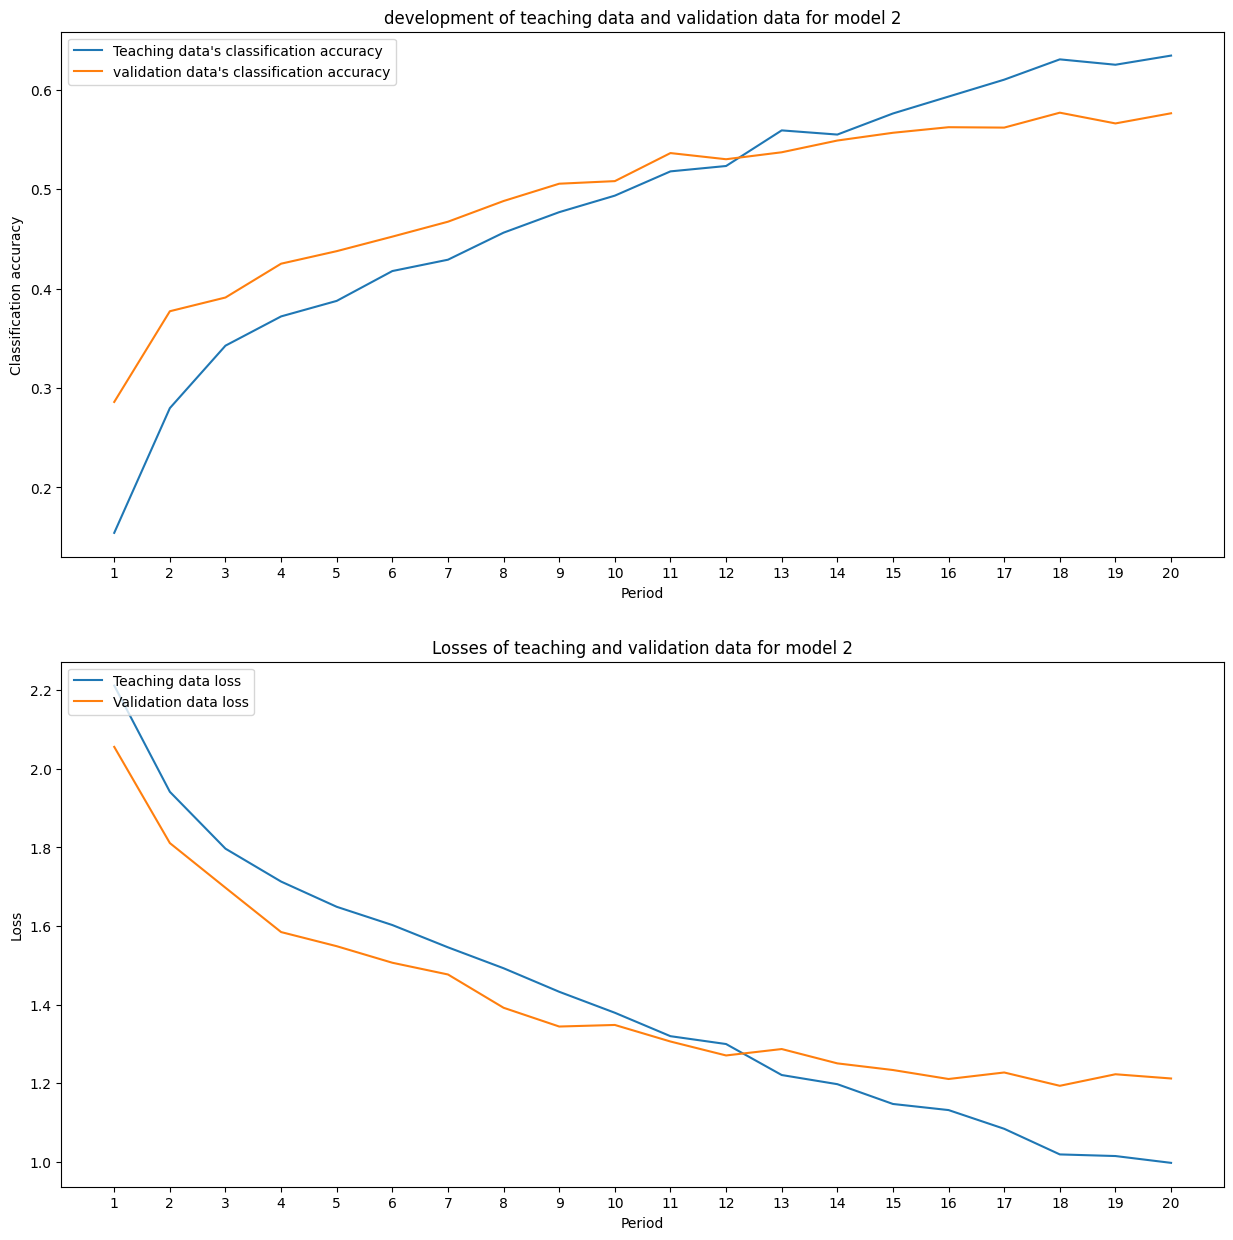

Classification accuracy for teaching data 20 after teaching period 63.42 %
Classification accuracy for validation data 20 after teaching period 57.62 %
Teaching data loss 20 after teaching period 0.997
Validation data loss 20 after teaching period 1.212


In [ ]:
def create_model2():
    """
    This function creates model2
    """
    # Initialize model1 consisting of consequent layers
    model2 = Sequential(name='model_2')
    model2.add(Input(shape=(32,32,3)))

    #-------YOUR CODE HERE--------
    # Add 3x3 convolution with zero-padding which produces 32 layers of features
    model2.add(Conv2D(32, (3,3), padding='same', name='Conv_1'))
    # Add ReLu-activation function
    model2.add(Activation('relu', name='ReLU_1'))
    # Add 3x3 convolution with zero-padding which produces 32 layers of features
    model2.add(Conv2D(32, (3,3), padding='same', name='Conv_2'))
    # Add ReLu-activation function
    model2.add(Activation('relu', name='ReLU_2'))
    # Add 2x2 max pooling layer
    model2.add(MaxPooling2D(pool_size=(2,2), name='MaxPooling_1'))
    # Add 30% neuron dropout layer
    model2.add(Dropout(0.3, name='Dropout_1'))

    # Add 3x3 convolution with zero-padding which produces 64 layers of features
    model2.add(Conv2D(64, (3,3), padding='same', name='Conv_3'))
    # Add ReLu-activation function
    model2.add(Activation('relu', name='ReLU_3'))
    # Add 3x3 convolution with zero-padding which produces 64 layers of features
    model2.add(Conv2D(64, (3,3), padding='same', name='Conv_4'))
    # Add ReLu-activation function
    model2.add(Activation('relu', name='ReLU_4'))
    # Add 2x2 max pooling layer
    model2.add(MaxPooling2D(pool_size=(2,2), name='MaxPooling_2'))
    # Add 40% neuron dropout layer
    model2.add(Dropout(0.4, name='Dropout_2'))

    # Add a flatten layer
    model2.add(Flatten(name='Flatten_1'))
    # Add a 128 neuron hidden layer
    model2.add(Dense(128, name='Dense_1'))
    # Add ReLu-activation function
    model2.add(Activation('relu', name='ReLU_5'))
    # Add 50% neuron dropout layer
    model2.add(Dropout(0.5, name='Dropout_3'))
    # Add Dense layer with 10 neurons
    model2.add(Dense(10, name='Dense_2'))
    # Add Softmax activation function
    model2.add(Activation('softmax', name='Softmax'))
    #--------------------------------

    # Define categorical crossentropy and ADAM-optimization as an error-function
    model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model2

# Create model 2
model2 = create_model2()
print(model2.summary())

# Teaching Model 2 and draw as a graph of teaching process
# Running this step might take a while
taught_model2 = model2.fit(data_teaching, classes_teaching_categorical, batch_size=64, epochs=20, validation_data=(data_validation, classes_validation_categorical), shuffle=True)
draw_graph_teaching_process(taught_model2, '2')

Create model 3 and teach it with CIFAR-10 data for 20 cycles when batch size is 64 layers. You can reduce variable *batch_size* to 32 or 16 samples if computer's memory is limited. Plot graph for model 3 and add teaching process teaching data and validation data's classification accuracies and losses on it.

Model: "model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 ReLU_1 (Activation)         (None, 32, 32, 32)        0         
                                                                 
 BatchNorm_1 (BatchNormaliz  (None, 32, 32, 32)        128       
 ation)                                                          
                                                                 
 Conv_2 (Conv2D)             (None, 32, 32, 32)        9248      
                                                                 
 ReLU_2 (Activation)         (None, 32, 32, 32)        0         
                                                                 
 BatchNorm_2 (BatchNormaliz  (None, 32, 32, 32)        128       
 ation)                                                     

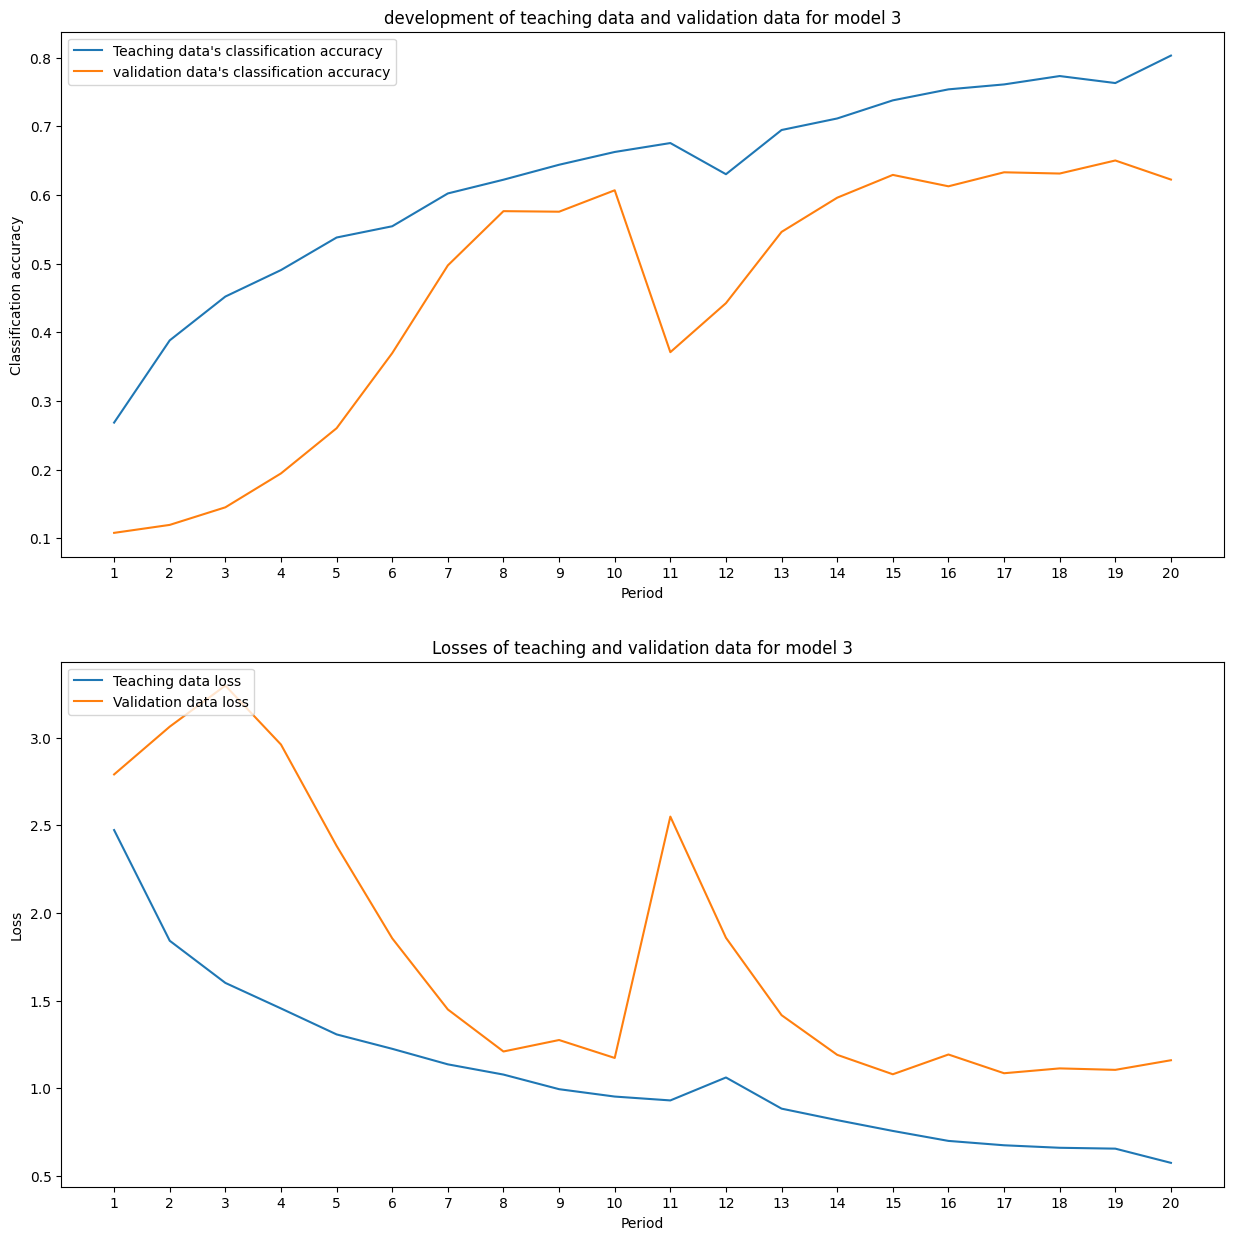

Classification accuracy for teaching data 20 after teaching period 80.3 %
Classification accuracy for validation data 20 after teaching period 62.24 %
Teaching data loss 20 after teaching period 0.574
Validation data loss 20 after teaching period 1.159


In [ ]:
def create_model3():
    """
    Tässä funktiossa luodaan konvoluutioneuroverkko model 3.
    """
    # Alustetaan peräkkäisistä kerroksista koostuva model
    model3 = Sequential(name='model3')
    model3.add(Input(shape=(32,32,3)))

    #-------YOUR CODE HERE--------
    # Add 3x3 convolution with zero-padding that produces 32 layers of features
    model3.add(Conv2D(32, (3,3), padding='same', name='Conv_1'))
    # Add the ReLu-activation function
    model3.add(Activation('relu', name='ReLU_1'))
    # Add normalization according to batch size
    model3.add(BatchNormalization(name='BatchNorm_1'))
    # Add 3x3 convolution with zero-padding that produces 32 layers of features
    model3.add(Conv2D(32, (3,3), padding='same', name='Conv_2'))
    # Add the ReLu-activation function
    model3.add(Activation('relu', name='ReLU_2'))
    # Add normalization according to batch size
    model3.add(BatchNormalization(name='BatchNorm_2'))
    # Add 2x2 max pooling layer
    model3.add(MaxPooling2D(pool_size=(2,2), name='MaxPooling_1'))
    # Add 30% neuron dropout layer
    model3.add(Dropout(0.3, name='Dropout_1'))

    # Add 3x3 convolution with a zero-padding that produces 64 layers of features
    model3.add(Conv2D(64, (3,3), padding='same', name='Conv_3'))
    # Add the ReLu-activation function
    model3.add(Activation('relu', name='ReLU_3'))
    # Add normalization according to batch size
    model3.add(BatchNormalization(name='BatchNorm_3'))
    # Add 3x3 convolution with a zero padding that produces 64 layers of features
    model3.add(Conv2D(64, (3,3), padding='same', name='Conv_4'))
    # Add the ReLu-activation function
    model3.add(Activation('relu', name='ReLU_4'))
    # Add normalization according to batch size
    model3.add(BatchNormalization(name='BatchNorm_4'))
    # Add 2x2 max pooling layer
    model3.add(MaxPooling2D(pool_size=(2,2), name='MaxPooling_2'))
    # Add 40% neuron dropout layer
    model3.add(Dropout(0.4, name='Dropout_2'))

    # Add a flatten layer
    model3.add(Flatten(name='Flatten_1'))
    # Add a hidden layer with 128 neurons
    model3.add(Dense(128, name='Dense_1'))
    # Add the ReLu-activation function
    model3.add(Activation('relu', name='ReLU_5'))
    # Add normalization according to batch size
    model3.add(BatchNormalization(name='BatchNorm_5'))
    # Add 50% of the neuron dropout layer
    model3.add(Dropout(0.5, name='Dropout_3'))
    # Add the Dense layer with 10 neurons
    model3.add(Dense(10, name='Dense_2'))
    # Add softmax activation function
    model3.add(Activation('softmax', name='Softmax'))
    #--------------------------------

    # Define categorical crossentropy and ADAM-optimization as an error-function
    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model3

# Create model 3
model3 = create_model3()
print(model3.summary())

# Teaching Model 3 and draw as a graph of teaching process
# Running this step might take a while
taught_model3 = model3.fit(data_teaching, classes_teaching_categorical, batch_size=64, epochs=20, validation_data=(data_validation, classes_validation_categorical), shuffle=True)
draw_graph_teaching_process(taught_model3, '3')

**Which of the taught convolutional neural network models is best? Whihc one on the other hand was most overfitted**

`The third model has the best performance with 64.32 % on the validation tests.

The first model is overfitted as has the highest accuracy on training dataset but poor perforamnce on validation set. 96.38 % vs 55.72 %`

After the teaching of the models, they are tested on the first sample of ValidationDATA 25. Drawing a picture of a validation sample, a category predicted to it, a predicted class posterior probability and brackets the correct category of sample. The color of the image text is blue when the forecast went right and red when it went wrong.

157/157 [==============================] - 8s 53ms/step


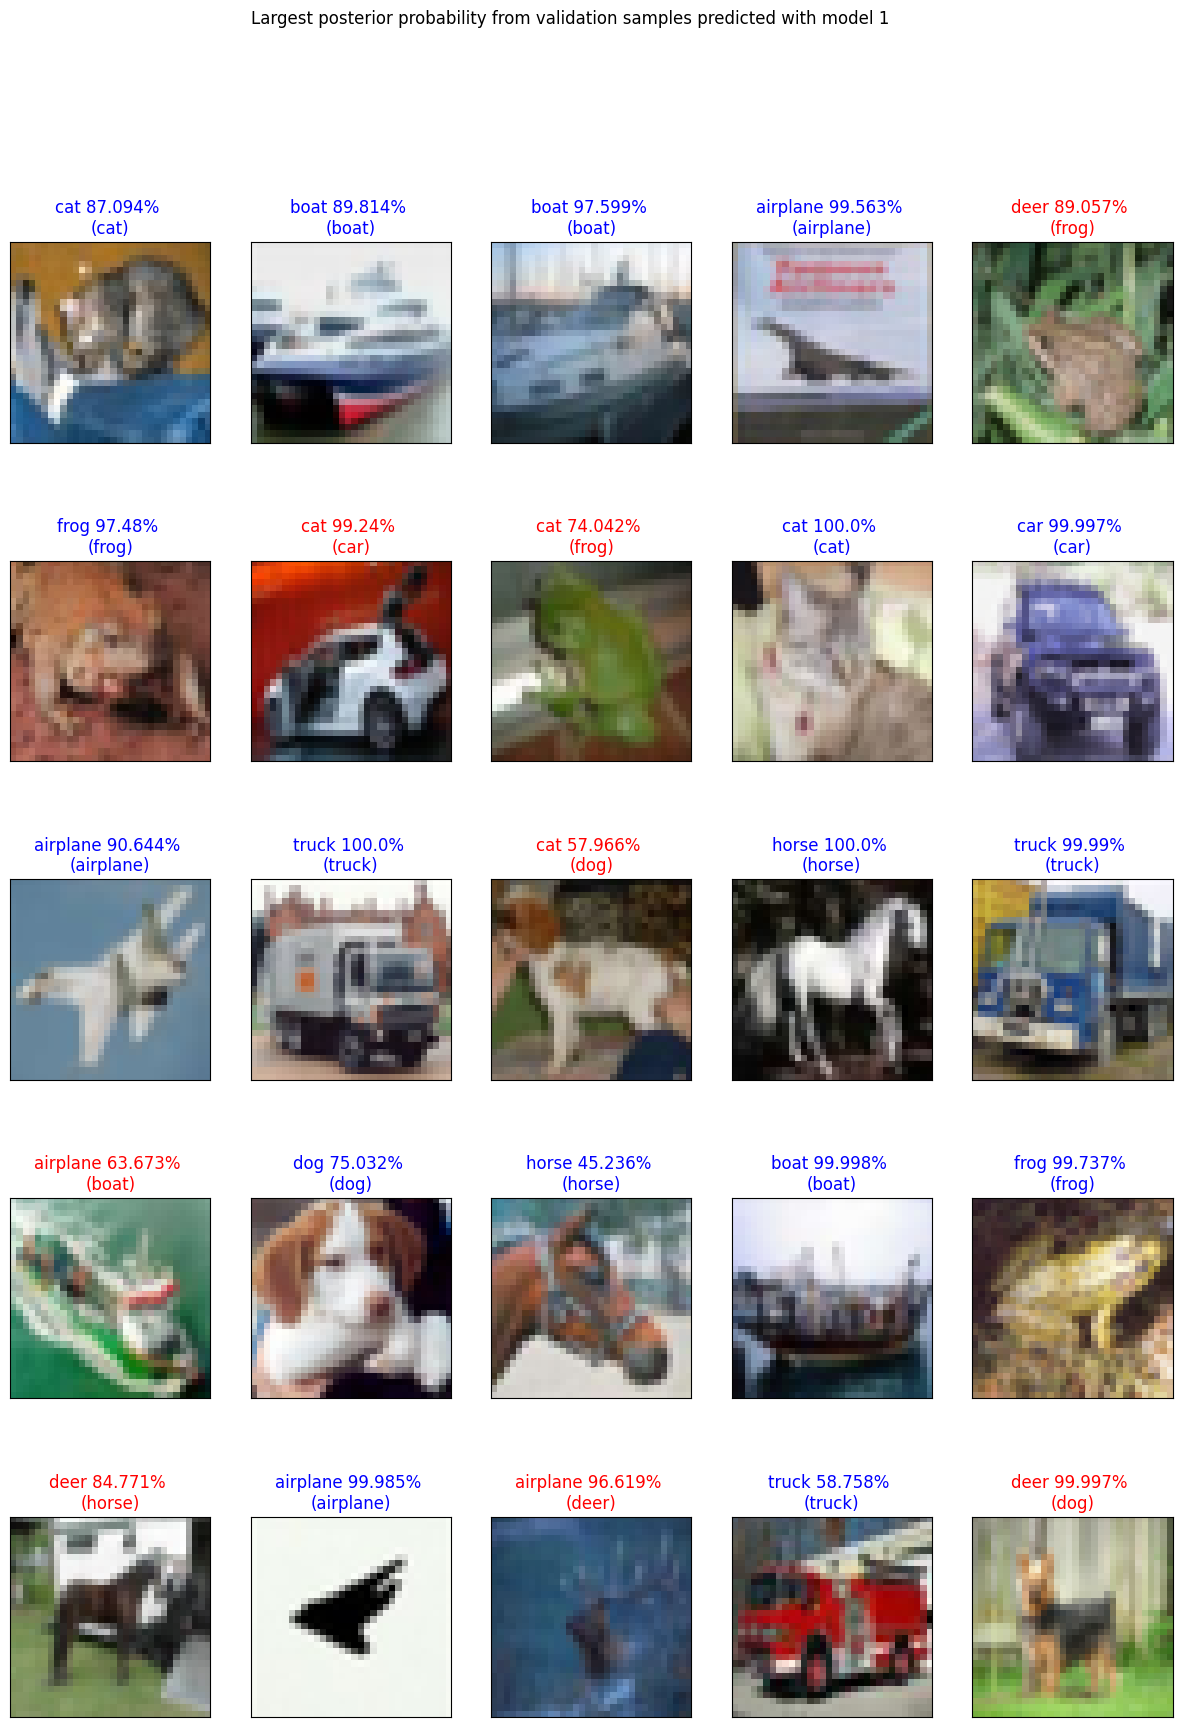

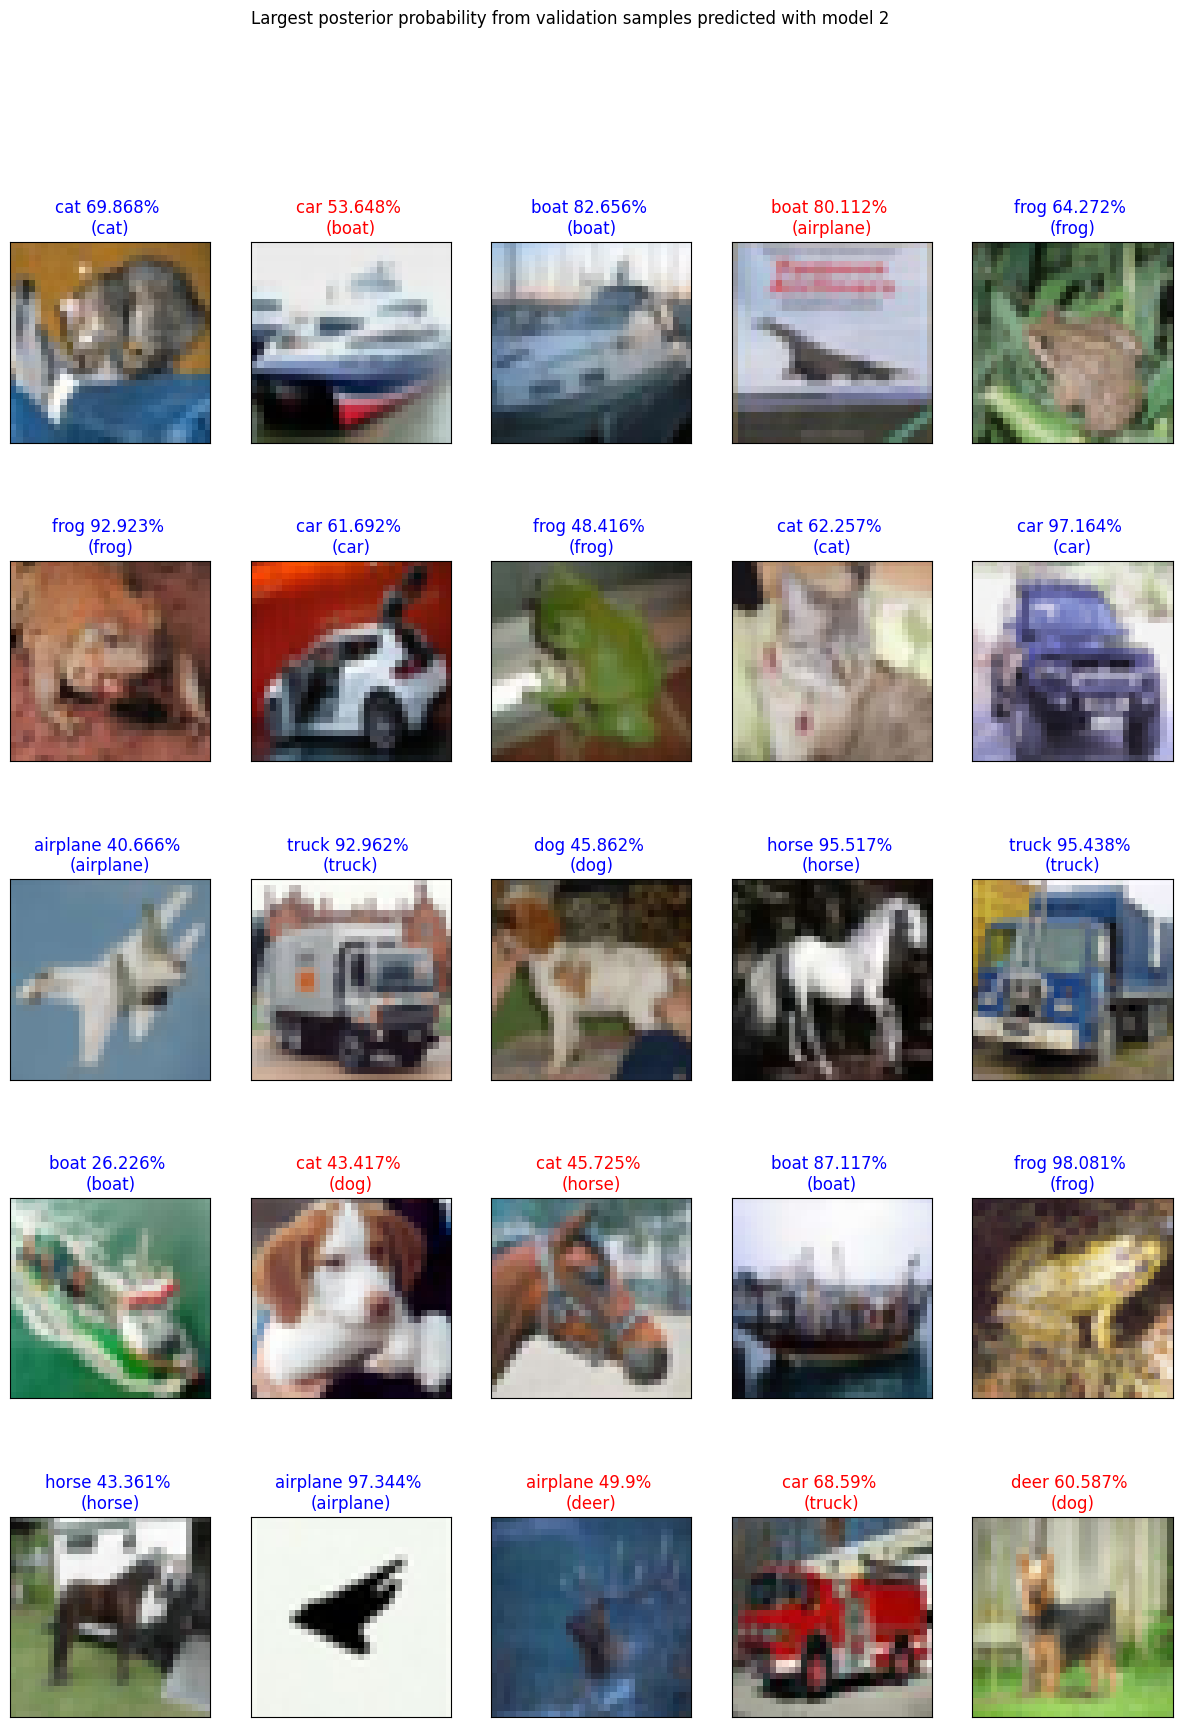

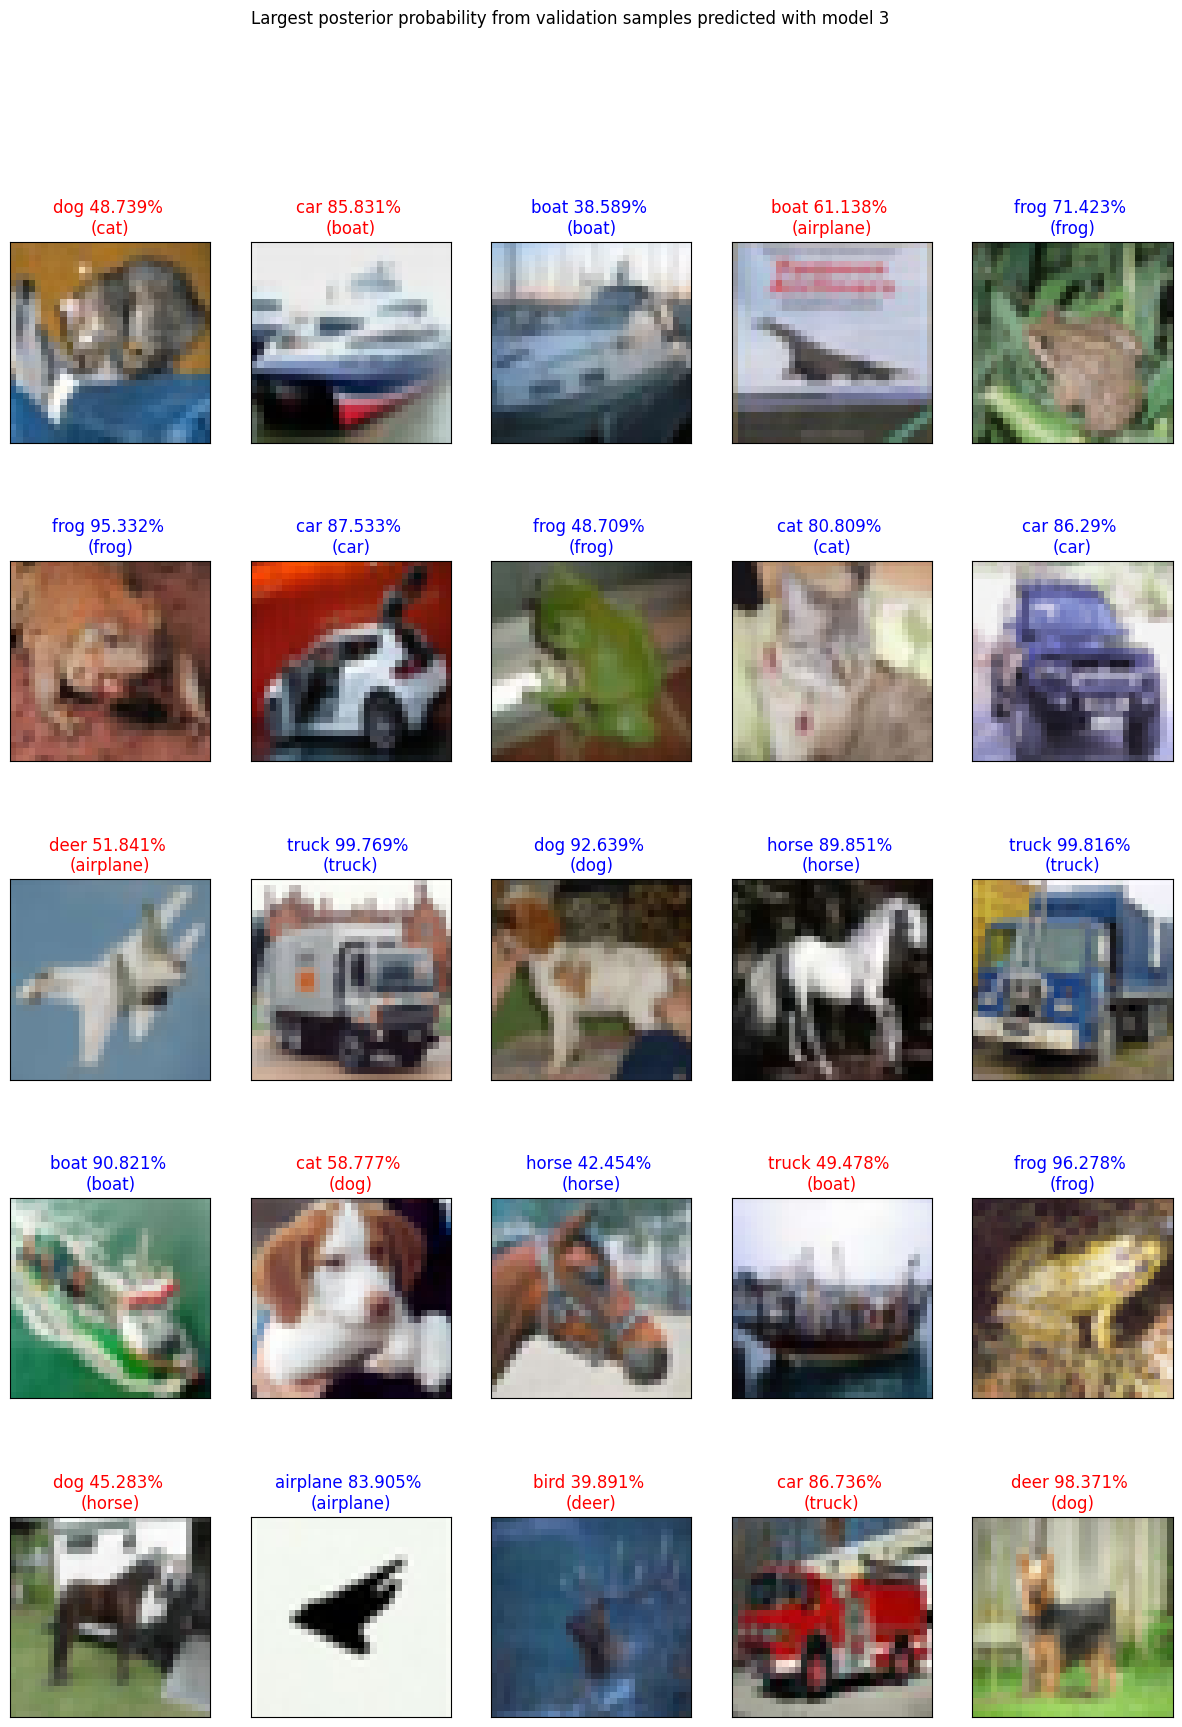

In [ ]:
def print_posterior_probabilities_for_predictions(model, model_name, data_validation, classes_validation, class_names, row_ammount, column_ammount):
    """
    Predict with model most probable class with posteriorprobabilities for test samples
    """
    predicted_classes = model.predict(data_validation)
    img_ammount = row_ammount*column_ammount
    plt.figure(figsize=(3*column_ammount, 4*row_ammount))
    plt.suptitle('Largest posterior probability from validation samples predicted with model {} '.format(model_name))
    for i in range(img_ammount):
        plt.subplot(row_ammount, column_ammount, i+1)
        predictions, right_class, img = predicted_classes[i], *classes_validation[i], data_validation[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)
        predicted_class = np.argmax(predictions)
        if predicted_class == right_class:
            color = 'blue'
        else:
            color = 'red'
        plt.title('{} {}% \n({})'.format(class_names[predicted_class], round(100*np.max(predictions),3), class_names[right_class]), color=color)

# Draw validation samples in image and predict with model 1 class which got highest posterior probability
print_posterior_probabilities_for_predictions(model1, '1', data_validation, classes_validation, class_names, 5, 5)

# Draw validation samples in image and predict with model 2 class which got highest posterior probability
print_posterior_probabilities_for_predictions(model2, '2', data_validation, classes_validation, class_names, 5, 5)

# Draw validation samples in image and predict with model 3 class which got highest posterior probability
print_posterior_probabilities_for_predictions(model3, '3', data_validation, classes_validation, class_names, 5, 5)

# Feedback

Finaly answer following questions

**How much time did you spend doing this exercise?**

`Your answer here`

**Did you encounter any problems or challenges while doing the exercise? Were the notebook sufficiently comprehensive instructions for doing the exercise?**

`Your answer here`

**Other feedback related to to this exercise?**

`Your answer here`

# Returning

1. Before you return this notebook **check that values are correct overall**. No need to run again because it takes quite long time.
2. Do not clear the printouts and variables, but press the save button after completing Step 1!
3. Rename this notebook in following format **`JT_H5_[student_number(s)].ipynb`** (e.g `JT_H5_1234567.ipynb` or if you have group `JT_H5_1234567_2345678_3456789.ipynb`)
4. Return **only** solved notebook(`file ending with .ipynb`) to moodle programming exercise 3. Everyone must return file to moodle even if you work in a group. **Don't include working directory or other files** when you return the exercise.
5. Finally go answer questions in moodle related to programming exercise 4. Everyone in your group must answer to questions.